This notebook explains the procedure to create drifts with a fault network, and the different models possible for drifts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.font_manager

# Load fault network

This notebook focuses on a simplified dataset compared to the global demo in order to be able to focus on the different steps of fault modeling.

In [2]:
try:
    df_faults = pd.read_csv("data/failles.csv")
except:
    df_faults = pd.read_csv("demo/data/failles.csv")


fault_names = np.array(['F_MercyLeHautCrusnes', 'F_Bonvillers','F_AudunLeRoman',
                        'F_Hayange', 'F_Fontoy', 'F_FontoyTer', 'F_FontoyBis'],
                        dtype=object)

faults = []
for name in fault_names:
    f = df_faults[df_faults["Nom"] == name]
    f = np.column_stack((f.X.values, f.Y.values))
    faults.append(f)

In [3]:
# Bounding box
xmin, xmax = 900000., 925000. 
ymin, ymax = 6910000., 6935000.

In [4]:
# Grid resolution along axis x and y, in meters
x_resolution = 100
y_resolution = 100

nb_pts_x, nb_pts_y = int((xmax-xmin)/x_resolution), int((ymax-ymin)/y_resolution)

dx = np.linspace(xmin, xmax, nb_pts_x)
dy = np.linspace(ymin, ymax, nb_pts_y)
x_grid, y_grid = np.meshgrid(dx, dy)
grid_points = (np.column_stack((x_grid.flat, y_grid.flat)))
print(f"Created rectangular interpolation grid of size {nb_pts_x}x{nb_pts_y} points, "
      f"with a resolution of {x_resolution}x{y_resolution} m.")

Created rectangular interpolation grid of size 250x250 points, with a resolution of 100x100 m.


In [5]:
%matplotlib inline
plt.figure()

plt.imshow(np.empty((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), alpha=0.)
for f in faults:
    plt.plot(f[...,0], f[...,1], 'r')

fault_legend = mlines.Line2D([],[], color='r', label="Fault traces")
plt.legend(handles=[fault_legend], fontsize=10)

plt.text(904_900, 6_922_000, "Mercy Le Haut Crusnes", rotation=55, color='red', fontsize=9)
plt.text(908_000, 6_921_000, "Audun Le Roman", rotation=35, color='red', fontsize=8)
plt.text(905_000, 6_914_000, "Bonvillers", rotation=60, color='red', fontsize=9)
plt.text(922_000, 6_921_500, "Hayange", rotation=50, color='red', fontsize=9)
plt.text(917_000, 6_921_500, "Fontoy", rotation=50, color='red', fontsize=9)
plt.text(916_500, 6_919_000, "Fontoy Bis", rotation=20, color='red', fontsize=8)
plt.text(912_000, 6_918_500, "Fontoy Ter", rotation=20, color='red', fontsize=8)

plt.title("Simplified fault network")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

plt.show()

C:\Users\janviert\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:455: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
C:\Users\janviert\AppData\Roaming\Python\Python39\site-packages\matplotlib\image.py:460: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


# Determine relations between faults

**plainKrige** proposes an automatic classification of faults in a network (with the function '*organize_drifts*')

It builds a matrix of relations between faults *i* and *j* with values:
- 0 if *i* is independant of *j*
- -1 if *i* stops on negative side of *j*
- 1 if *i* stops on positive side of *j*

The resulting matrix must be read line by line : each line represents a fault and its relations to others. The diagonal is forced to be zero. 

The '*buffer*' parameter accounts for the precision of the traces coordinates : it represents the maximum distance a fault can cross another one and still be considered stopping on the other fault. It can be unique for the fault network or be different for each fault (for instance a function of the total fault length of the fault trace). Here, we use *buffer = fault length/100* by default.

In [6]:
from plainkrige import build_drift, build_network, build_fault

In [7]:
buffer = np.linalg.norm([f[0] - f[-1] for f in faults], axis=-1) / 100
drift_network = build_network(faults, buffer=100)
matrix = drift_network.matrix
print(f"Proposed matrix of relations between faults (in order : {fault_names})\n", matrix)

Proposed matrix of relations between faults (in order : ['F_MercyLeHautCrusnes' 'F_Bonvillers' 'F_AudunLeRoman' 'F_Hayange'
 'F_Fontoy' 'F_FontoyTer' 'F_FontoyBis'])
 [[ 0  1  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0]
 [ 0 -1  0  0 -1  0  0]
 [ 0  0  0  0  1  0  1]
 [ 0 -1 -1  1  0  0  0]
 [ 0 -1  0  0 -1  0  0]
 [ 0  0  0  1  1  0  0]]


# Choose model for each fault

The next step after selecting the fault network is to compute drifts associated to this network. Each fault will be represented by one function of the space coordinates, defining what is the influence of the fault on this point. These functions return a float value between -1 and 1 for a given point. 

0 means that the fault has no impact on this point. Else, the sign determines on which side of the fault the point is. 

The drift can be of different types :
- '*heaviside*' : infinite influence with no attenuation
  - '*infinite heaviside*' : the fault influence is prolonged at its extremities
  - '*finite heaviside*' : the fault influence stops exactly on the tip of the fault.
- '*gaussian*' : fault influence vanishes with increasing distance to the fault.
  - '*infinite gaussian*' : the fault influence is prolonged at its extremities
  - '*finite gaussian*' : the fault influence stops exactly on the tip of the fault.

Parameters are :
- *model* : either 'heaviside' or 'gaussian'
- *range* : distance of influence
- *extent* : determines whether the influence stops exactly at the tip of the fault or not.. If *extent = np.inf*, fault is infinite. By default, *extent = fault length*.

The four possible types of drifts are plotted below for more clarity.

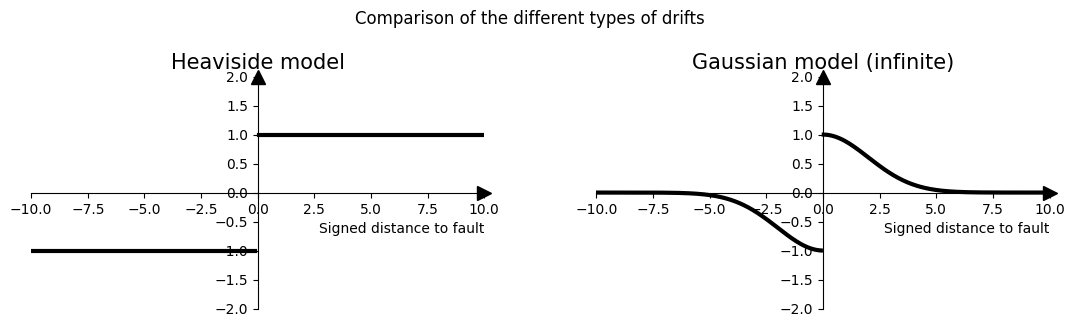

In [8]:
x = np.linspace(-10, 10, 300)
x = np.insert(x, np.where(np.abs(x) < 0.05)[0], np.nan)
y_heaviside = np.piecewise(x,
                    [
                        x < 0,
                        x > 0
                    ],
                    [
                        -1,
                        1
                    ],
                )
d = 2
y_gaussian = np.exp(- x**2 / (2 * (d**2)))
y_gaussian[x<0] *= -1


fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout(pad=5.)

ax[0].spines['left'].set_position('center')
ax[0].spines['bottom'].set_position('center')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].xaxis.set_ticks_position('bottom')
ax[0].yaxis.set_ticks_position('left')

ax[0].set_ylim(-2,2)
ax[0].set_xlim(-10,10)
ax[0].set_xlabel("Signed distance to fault", loc="right")

ax[0].plot(x,y_heaviside, 'k', linewidth=3)

ax[0].set_title("Heaviside model", fontsize=15)


ax[1].spines['left'].set_position('center')
ax[1].spines['bottom'].set_position('center')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].xaxis.set_ticks_position('bottom')
ax[1].yaxis.set_ticks_position('left')

ax[1].set_ylim(-2,2)
ax[1].set_xlim(-10,10)
ax[1].set_xlabel("Signed distance to fault", loc="right")

ax[1].plot(x,y_gaussian, 'k', linewidth=3)

ax[1].set_title("Gaussian model (infinite)", fontsize=15)

ax[0].plot((1), (0), ls="", marker=">", ms=10, color="k",
            transform=ax[0].get_yaxis_transform(), clip_on=False)
ax[0].plot((0), (1), ls="", marker="^", ms=10, color="k",
            transform=ax[0].get_xaxis_transform(), clip_on=False)

ax[1].plot((1), (0), ls="", marker=">", ms=10, color="k",
            transform=ax[1].get_yaxis_transform(), clip_on=False)
ax[1].plot((0), (1), ls="", marker="^", ms=10, color="k",
            transform=ax[1].get_xaxis_transform(), clip_on=False)

fig.suptitle("Comparison of the different types of drifts")
plt.show()

In [9]:
from plainkrige import build_drift, build_fault

In [10]:

model_range_comparison = np.linalg.norm(faults[0][0] - faults[0][-1])/2
matrix_line = np.asarray([0, 0, 0, 0, 0, 0, 0])

heaviside = build_drift(build_fault(faults[0]), model='heaviside')(grid_points)
inf_heaviside = build_drift(build_fault(faults[0]), model='heaviside', extent=np.inf)(grid_points)
gaussian = build_drift(build_fault(faults[0]), model='gaussian', range=model_range_comparison, extent=np.inf)(grid_points)
finite_gaussian = build_drift(build_fault(faults[0]), model='gaussian', range=model_range_comparison)(grid_points)

In [11]:
# Compare types of drifts

fig, ax = plt.subplots(2,2, figsize=(8,7))
fig.tight_layout(pad=2., rect=[0, 0.03, 1, 0.95])

d = ax[0,0].imshow(inf_heaviside.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
ax[0,0].plot(faults[0][...,0], faults[0][...,1], 'r')
ax[0,0].set_title("Infinite Heaviside")

ax[0,1].imshow(heaviside.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
ax[0,1].contour(np.abs(heaviside.reshape((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), levels=[0.05], colors='black',linestyles='dotted')
ax[0,1].plot(faults[0][...,0], faults[0][...,1], 'r')
ax[0,1].set_title("Finite Heaviside")

ax[1,0].imshow(gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
ax[1,0].contour(np.abs(gaussian.reshape((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), levels=[0.05], colors='black',linestyles='dotted')
ax[1,0].plot(faults[0][...,0], faults[0][...,1], 'r')
ax[1,0].set_title("Infinite gaussian")

ax[1,1].imshow(finite_gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
ax[1,1].contour(np.abs(finite_gaussian.reshape((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), levels=[0.05], colors='black',linestyles='dotted')
ax[1,1].plot(faults[0][...,0], faults[0][...,1], 'r')
ax[1,1].set_title("Finite gaussian")

fig.suptitle(f"Comparison of the different types of drifts in map view", fontsize=15)

cax = fig.add_axes([ax[1,1].get_position().x1 + 0.02,
                    (ax[0,1].get_position().y0 + ax[1,1].get_position().y0)/2,
                    0.01,
                    ax[0,0].get_position().y1 - ax[0,0].get_position().y0])

ax[0,0].set_xticks([900000, 910000, 920000])
ax[0,1].set_xticks([900000, 910000, 920000])
ax[1,0].set_xticks([900000, 910000, 920000])
ax[1,1].set_xticks([900000, 910000, 920000])

plt.colorbar(d, label="Drift", cax=cax)

fault_legend = mlines.Line2D([],[], color='r', label="Fault traces")
limits_legend = mlines.Line2D([],[], color='k', linestyle="dotted", label=r"$|drift| = 0.05$")
plt.legend(handles=[fault_legend, limits_legend], fontsize=10, loc=(0.9, 1.3))

plt.show()

Now, let's plot the four different types of drifts for the whole network, respecting the automatic relations inferred with *organize_drifts*.

## Heaviside model

In [12]:
heaviside_params={"extent":np.inf}

In [13]:
heaviside_drifts = build_network(faults, relations=matrix, models="heaviside", params=heaviside_params)

In [14]:
heaviside_drifts_on_grid = heaviside_drifts(grid_points)

In [15]:
def plot_drifts(computed_drifts, title):
    fig, ax = plt.subplots(2,4, figsize=(12,6))
    fig.suptitle(title)

    for i in range(2):
        for j in range(4):
            if i*4+j==7:
                ax[i,j].remove()
            else:
                d = ax[i,j].imshow(computed_drifts[i*4+j].reshape(((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[-1,1], cmap="coolwarm")
                ctr = ax[i,j].contour(np.abs(computed_drifts[i*4+j].reshape((nb_pts_y, nb_pts_x))), origin="lower", extent=(xmin, xmax, ymin, ymax), levels=[0.05], colors='black',linestyles='dotted')
                for f in faults:
                    ax[i,j].plot(f[...,0], f[...,1], 'r')
                ax[i,j].plot(faults[i*4+j][...,0], faults[i*4+j][...,1], 'black', linewidth=2)
                ax[i,j].set_title(fault_names[i*4+j])

    # Add legend
    network_legend = mlines.Line2D([],[], color='r', label="Rest of the network")
    current_legend = mlines.Line2D([],[], color='k', label="Fault of interest")
    fig.legend(handles=[current_legend, network_legend], fontsize=10, loc=(0.82, 0.1), title="Legend:", title_fontproperties=matplotlib.font_manager.FontProperties(weight="bold"))

    cax = fig.add_axes([ax[1,2].get_position().x1+0.02,
                        ax[1,0].get_position().y0,
                        0.01,
                        ax[1,0].get_position().y1-ax[1,0].get_position().y0])

    plt.colorbar(d, label="Drift", cax=cax)

    plt.show()

In [16]:
plot_drifts(heaviside_drifts_on_grid, "Heaviside drifts")

## Finite Heaviside model

In [17]:
# Finite heaviside is the default choice so no need to fill params
finite_heaviside_params = {}

In [18]:
finite_heaviside_drifts = build_network(faults, relations=matrix, models="heaviside", params=finite_heaviside_params)

In [19]:
finite_heaviside_drifts_on_grid = finite_heaviside_drifts(grid_points)

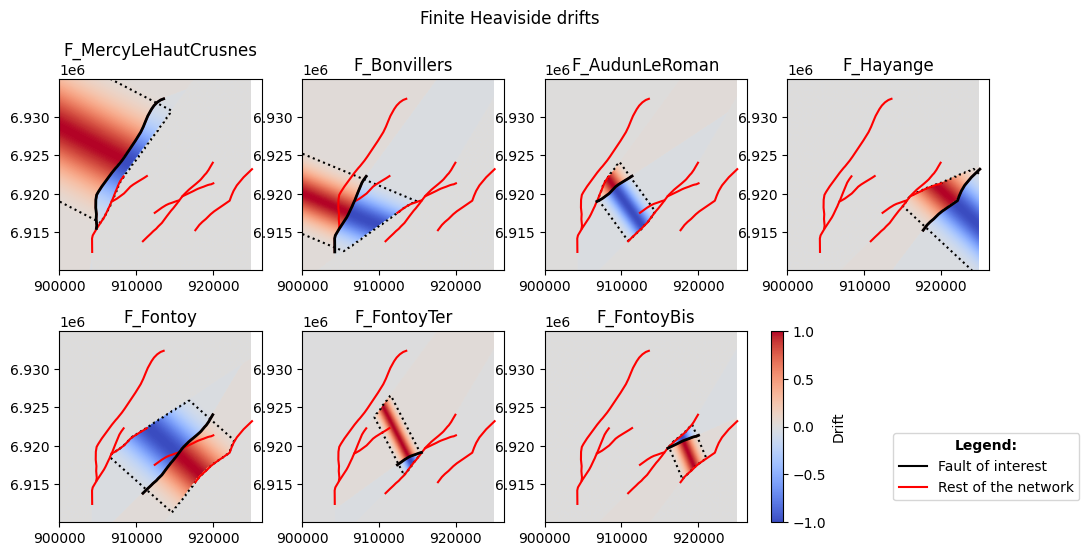

In [20]:
plot_drifts(finite_heaviside_drifts_on_grid, "Finite Heaviside drifts")

## Infinite gaussian model

Define dictionnary of parameters for each fault, based on fault lengths.

In [21]:
# Gets approximate fault lengths
ranges=[np.linalg.norm(f[0] - f[-1]) for f in faults]
# Creates a list of dictionnaries : one by fault.
inf_gaussian_params = []
for r in ranges:
    inf_gaussian_params.append({"extent":np.inf, "range":r})

In [22]:
gaussian_drifts = build_network(faults, relations=matrix, models="gaussian", params=inf_gaussian_params)

In [23]:
gaussian_drifts_on_grid = gaussian_drifts(grid_points)

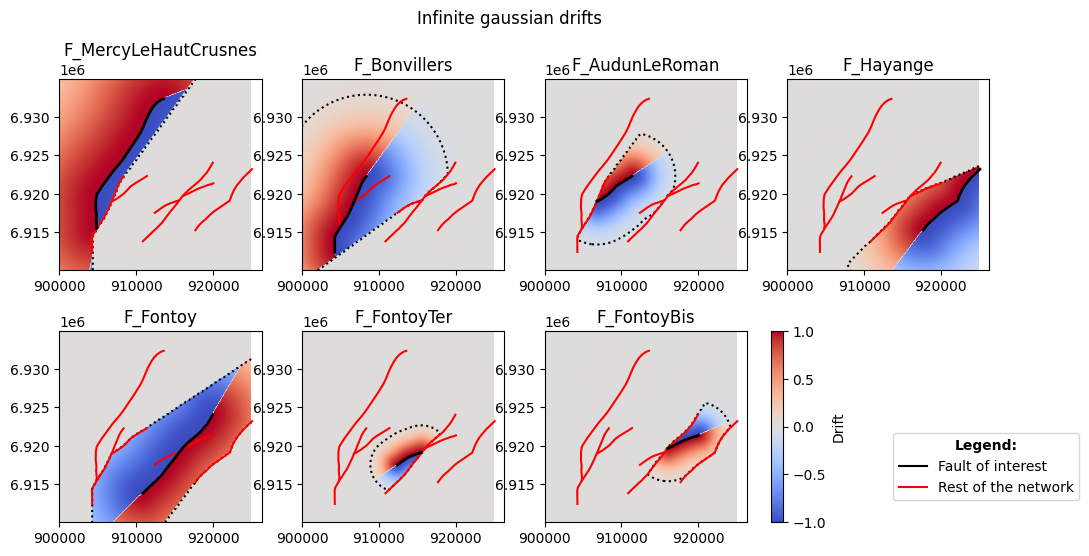

In [24]:
plot_drifts(gaussian_drifts_on_grid, "Infinite gaussian drifts")

## Finite gaussian model

In [25]:
ranges=[np.linalg.norm(f[0] - f[-1]) for f in faults]
finite_gaussian_params = []
for r in ranges:
    finite_gaussian_params.append({"range":r})

In [26]:
finite_gaussian_drifts = build_network(faults, relations=matrix, models="gaussian", params=finite_gaussian_params)

In [27]:
finite_gaussian_drifts_on_grid = finite_gaussian_drifts(grid_points)

In [28]:
plot_drifts(finite_gaussian_drifts_on_grid, "Finite gaussian drifts")

# Synthetic result

These results can be summarized into a unique plot to rapidly identify 'fault blocs'. These limits are caracterized by a discontinuity in the computed drifts. Thus, we can compute the derivative of drifts on the interpolation grid and, given a threshold, identify a limit. This is done for each fault in *faults* and summarized into a unique np.array of booleans representing discontinuities on the domain. 

In [29]:
def get_limits(computed_drifts, threshold=0.1):
    derivative = np.asarray([np.asarray(np.gradient(d.reshape((nb_pts_y, nb_pts_x)))) for d in computed_drifts])
    derivative = np.any(np.abs(derivative) > threshold, axis=1)
    return derivative

In [30]:
threshold = 0.1

In [31]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(pad=5.)

ax[0,0].imshow(np.any(get_limits(heaviside_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[0,1].imshow(np.any(get_limits(finite_heaviside_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[1,0].imshow(np.any(get_limits(gaussian_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[1,1].imshow(np.any(get_limits(finite_gaussian_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

fault_style = (0, (3,1.5))
for f in faults:
        ax[0,0].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[0,1].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[1,0].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[1,1].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)

fault_legend = mlines.Line2D([], [], color='r', label="Faults", linestyle=fault_style)
limits_legend = mlines.Line2D([], [], color='k', label="Discontinuities")

fig.legend(handles=[fault_legend, limits_legend], facecolor="silver", loc="center left", bbox_to_anchor=(0.,0.95), fontsize=9)

ax[0,0].set_xticks([900000, 910000, 920000])
ax[0,1].set_xticks([900000, 910000, 920000])
ax[1,0].set_xticks([900000, 910000, 920000])
ax[1,1].set_xticks([900000, 910000, 920000])

ax[0,0].set_title("Heaviside")
ax[0,1].set_title("Finite Heaviside")
ax[1,0].set_title("Gaussian")
ax[1,1].set_title("Finite gaussian")

plt.suptitle("Discontinuities introduced by drifts", fontsize=15)
plt.show()

These plots can outline different problems in the definition of drifts and/or their relations : discontinuities crossing each other, fault blocs geologically inconsistent, ...

# Corrections

We can now define manually a matrix of relations, that corrects the problems identified thanks to the automatic classification. 

In [32]:
corrected_matrix = np.asarray([
    [ 0 , 0 , 0 , 0 , 0 , 0 , 0],
    [ 0 , 0 , 0 , 0 , 0 , 0 , 0],
    [ 0 ,-1 , 0 , 0 ,-1 , 0 , 0],
    [ 0 , 0 , 0 , 0 , 0 , 0 , 0],
    [ 0 , 0 , 0 , 0 , 0 , 0 , 0],
    [ 0 ,-1 , 0 , 0 ,-1 , 0 , 0],
    [ 0 , 0 , 0 , 1 , 1 , 0 , 0],
    ], dtype=int)

In [33]:
corrected_heaviside_drifts = build_network(faults, relations=corrected_matrix, models="heaviside", params=heaviside_params)
corrected_finite_heaviside_drifts = build_network(faults, relations=corrected_matrix, models="heaviside", params=finite_heaviside_params)
corrected_gaussian_drifts = build_network(faults, relations=corrected_matrix, models="gaussian", params=inf_gaussian_params)
corrected_finite_gaussian_drifts = build_network(faults, relations=corrected_matrix, models="gaussian", params=finite_gaussian_params)

In [34]:
corrected_heaviside_drifts_on_grid = corrected_heaviside_drifts(grid_points)
corrected_finite_heaviside_drifts_on_grid = corrected_finite_heaviside_drifts(grid_points)
corrected_gaussian_drifts_on_grid = corrected_gaussian_drifts(grid_points)
corrected_finite_gaussian_drifts_on_grid = corrected_finite_gaussian_drifts(grid_points)

In [35]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(pad=5.)

fault_style = (0, (3,1.5))
for f in faults:
        ax[0,0].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[0,1].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[1,0].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)
        ax[1,1].plot(f[...,0], f[...,1], 'r', linestyle=fault_style, linewidth=2.5)

ax[0,0].imshow(np.any(get_limits(corrected_heaviside_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[0,1].imshow(np.any(get_limits(corrected_finite_heaviside_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[1,0].imshow(np.any(get_limits(corrected_gaussian_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))

ax[1,1].imshow(np.any(get_limits(corrected_finite_gaussian_drifts_on_grid, threshold), axis=0), origin="lower", cmap='Greys', extent=(xmin,xmax,ymin,ymax))


fault_legend = mlines.Line2D([], [], color='r', label="Faults", linestyle=fault_style)
limits_legend = mlines.Line2D([], [], color='k', label="Discontinuities")

fig.legend(handles=[fault_legend, limits_legend], facecolor="silver", loc="center left", bbox_to_anchor=(0.,0.95), fontsize=9)

ax[0,0].set_xticks([900000, 910000, 920000])
ax[0,1].set_xticks([900000, 910000, 920000])
ax[1,0].set_xticks([900000, 910000, 920000])
ax[1,1].set_xticks([900000, 910000, 920000])

ax[0,0].set_title("Heaviside")
ax[0,1].set_title("Finite Heaviside")
ax[1,0].set_title("Gaussian")
ax[1,1].set_title("Finite gaussian")

plt.suptitle("Discontinuities introduced by drifts", fontsize=15)
plt.show()

# Kriging with the four types of drifts

In [36]:
from plainkrige import UniversalKriging, OrdinaryKriging

In [37]:
# Import data
try:
    df_contacts = pd.read_csv("data/contacts.csv")
except:
    df_contacts = pd.read_csv("demo/data/contacts.csv")

formation = df_contacts[df_contacts['Formation'] == 'G']
formation = formation.dropna() # Drop rows with missing values

# Get data points
x, y = formation.X_L93.values, formation.Y_L93.values
data_pts = np.column_stack((x,y))
# get elevation at data points 
data = formation.Zt.values 

In [38]:
from plainkrige.covariance import covariance_models

We use an auto-fitted gaussian variogram model

In [ ]:
lag_max = 10_000
nbins = 10

In [39]:
cov = covariance_models["gaussian"](sill=5_000, range=5_000, nugget=200)
_, cov_mse = cov.fit(data_pts, lag_max=lag_max, nbins=nbins, values=data)

In [40]:
krige_heaviside = UniversalKriging(data_pts, lag_max, nbins, data, cov, corrected_heaviside_drifts)(grid_points)
krige_finite_heaviside = UniversalKriging(data_pts, lag_max, nbins, data, cov, corrected_finite_heaviside_drifts)(grid_points)

krige_gaussian = UniversalKriging(data_pts, lag_max, nbins, data, cov, corrected_gaussian_drifts)(grid_points)
krige_finite_gaussian = UniversalKriging(data_pts, lag_max, nbins, data, cov, corrected_finite_gaussian_drifts)(grid_points)

In [41]:
# Plot result
%matplotlib inline

clim_min, clim_max = -100, 400
plot_contour = False

fig, ax = plt.subplots(2,2, figsize=(10,8), gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1,1]})
fig.tight_layout(pad=5)

# Heaviside
h = ax[0,0].imshow(krige_heaviside.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])

# Finite heaviside
fh = ax[0,1].imshow(krige_finite_heaviside.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])

# Gaussian
g = ax[1,0].imshow(krige_gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])
if plot_contour: ctr_ord = ax[1,0].contour(krige_gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", levels=[-50,50,150,250,350,450], extent=(xmin, xmax, ymin, ymax), cmap="Oranges")

# Finite gaussian
fg = ax[1,1].imshow(krige_finite_gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", extent=(xmin, xmax, ymin, ymax), clim=[clim_min, clim_max])
if plot_contour: ctr_univ = ax[1,1].contour(krige_finite_gaussian.reshape((nb_pts_y, nb_pts_x)), origin="lower", levels=[-50,50,150,250,350,450], extent=(xmin, xmax, ymin, ymax), cmap="Oranges")

# Faults
fault_style = (0, (3,1.5))
for f in faults:
        ax[0,0].plot(f[...,0], f[...,1], 'r', linewidth=2, linestyle=fault_style)
        ax[0,1].plot(f[...,0], f[...,1], 'r', linewidth=2, linestyle=fault_style)
        ax[1,0].plot(f[...,0], f[...,1], 'r', linewidth=2, linestyle=fault_style)
        ax[1,1].plot(f[...,0], f[...,1], 'r', linewidth=2, linestyle=fault_style)

ax[0,0].set_title("Heaviside")
ax[0,1].set_title("Finite Heaviside")
ax[1,0].set_title("Gaussian")
ax[1,1].set_title("Finite gaussian")

plt.suptitle(f"Result of kriging for formation FF with simplified fault network")

ax[0,0].set_xlabel("X")
ax[0,1].set_xlabel("X")
ax[1,0].set_xlabel("X")
ax[1,1].set_xlabel("X")

ax[0,0].set_ylabel("Y")
ax[0,1].set_ylabel("Y")
ax[1,0].set_ylabel("Y")
ax[1,1].set_ylabel("Y")

ax[0,0].set_xticks([900000, 910000, 925000])
ax[0,1].set_xticks([900000, 910000, 925000])
ax[1,0].set_xticks([900000, 910000, 925000])
ax[1,1].set_xticks([900000, 910000, 925000])

# Kriging parameters
# ax[1].text(xmin + 1000, ymax - 7000, f"model : {vario_type}\nrange : {range_vario:4.0f}\n sill : {sill_vario:4.0f}\n nugget : {nugget:4.0f}", color='white')
# ax[2].text(xmin + 1000, ymax - 7000, f"model : {vario_type}\nrange : {range_vario:4.0f}\n sill : {sill_vario:4.0f}\n nugget : {nugget:4.0f}", color='white')

cax = fig.add_axes([ax[0,1].get_position().x1+0.02,
                    (ax[0,1].get_position().y0 + ax[1,1].get_position().y0)/2,
                    0.01,
                    ax[0,1].get_position().y1-ax[0,1].get_position().y0])

fault_legend = mlines.Line2D([], [], color='r', label="Faults", linestyle=fault_style)
data_legend = mlines.Line2D([], [], color='k', label="Data points", linestyle="none", marker='x')
plt.legend(handles=[fault_legend], facecolor="white", loc="center left", bbox_to_anchor=(0.,1.2))

cbar = plt.colorbar(h, label="Elevation (m)", cax=cax)
if plot_contour: cbar.add_lines(ctr_ord)

plt.show()

# 3D visualisation

In [42]:
import pyvista as pv

In [43]:
vertical_exaggeration = 8

In [44]:
surf_h = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_heaviside)))
surf_h = surf_h.delaunay_2d()

surf_fh = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_finite_heaviside)))
surf_fh = surf_fh.delaunay_2d()

surf_g = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_gaussian)))
surf_g = surf_g.delaunay_2d()

surf_fg = pv.PolyData(np.column_stack((x_grid.flat, y_grid.flat, krige_finite_gaussian)))
surf_fg = surf_fg.delaunay_2d()

In [45]:
surf_h["elevation"] = surf_h.points[...,2]
surf_h.points[...,2]*=vertical_exaggeration

surf_fh["elevation"] = surf_fh.points[...,2]
surf_fh.points[...,2]*=vertical_exaggeration

surf_g["elevation"] = surf_g.points[...,2]
surf_g.points[...,2]*=vertical_exaggeration

surf_fg["elevation"] = surf_fg.points[...,2]
surf_fg.points[...,2]*=vertical_exaggeration

In [52]:
plotter = pv.Plotter(notebook=True)

mesh_h = plotter.add_mesh(surf_h, clim=[clim_min, clim_max])
mesh_fh = plotter.add_mesh(surf_fh, clim=[clim_min, clim_max])
mesh_g = plotter.add_mesh(surf_g, clim=[clim_min, clim_max])
mesh_fg = plotter.add_mesh(surf_fg, clim=[clim_min, clim_max])

# Create checkboxes to select the surface to plot
plotter.add_checkbox_button_widget(lambda x: mesh_h.SetVisibility(x), value=True)
plotter.add_checkbox_button_widget(lambda x: mesh_fh.SetVisibility(x), value=False, position=(10,60))
plotter.add_checkbox_button_widget(lambda x: mesh_g.SetVisibility(x), value=False, position=(10,110))
plotter.add_checkbox_button_widget(lambda x: mesh_fg.SetVisibility(x), value=False, position=(10,160))

plotter.add_text("Heaviside", position=(70,10))
plotter.add_text("Finite Heaviside", position=(70,60))
plotter.add_text("Gaussian", position=(70,110))
plotter.add_text("Finite gaussian", position=(70,160))

plotter.show(jupyter_backend='server')